<a href="https://colab.research.google.com/github/yu0ki/BERT_Practice/blob/main/Chapter10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
BERTは文章をトークン化したものを入力すると、各トークンに対応するベクトルを返してくれる
このベクトルを集約することで、文章全体の意味を反映したベクトル(=文章ベクトル)を作ることができる

そして、こうしたベクトルの類似度を求めることで文章同士の内容の類似度を比べられる


文章ベクトルのゲット方法 - 2パターン
1. [CLS]に対応するベクトルを使う
2. BERTからの出力ベクトルの平均を取る

BERTの元論文では1が使われていた
しかし、最近の論文では2の方が性能が良いという結果も出ている
今回は2で行くことにする

'''

'\nBERTは文章をトークン化したものを入力すると、各トークンに対応するベクトルを返してくれる\nこのベクトルを集約することで、文章全体の意味を反映したベクトル(=文章ベクトル)を作ることができる\n\nそして、こうしたベクトルの類似度を求めることで文章同士の内容の類似度を比べられる\n\n\n文章ベクトルのゲット方法 - 2パターン\n1. [CLS]に対応するベクトルを使う\n2. BERTからの出力ベクトルの平均を取る\n\nBERTの元論文では1が使われていた\nしかし、最近の論文では2の方が性能が良いという結果も出ている\n今回は2で行くことにする\n\n'

In [2]:
!mkdir chap10
%cd ./chap10

/content/chap10


In [3]:
# ライブラリインストール
!pip install transformers==4.18.0 fugashi==1.1.0 ipadic==1.0.0

import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

# BERTの日本語モデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 4.6 MB/s 
     |████████████████████████████████| 486 kB 63.9 MB/s 
     |████████████████████████████████| 13.4 MB 45.0 MB/s 
     |████████████████████████████████| 120 kB 68.5 MB/s 
     |████████████████████████████████| 880 kB 64.9 MB/s 
     |████████████████████████████████| 6.6 MB 58.2 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=864a9e76467db678311d1aefd9d4ba755b9e9105e4f63360ed66801813278df5
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=36b11ca38619fd1950b8badd7966321cc3614b516fd2925cdb292c4bf2640e33
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built ipadic 

In [4]:
# とりあえずデータセットをダウンロードしよう
# livedoorニュースコーパスを使うぞ

#データのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz 
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz 

--2022-09-22 11:57:34--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  4.10MB/s    in 2.1s    

2022-09-22 11:57:37 (4.10 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



In [5]:
'''
データを取り込んで、文章ベクトル(1記事に対して1ベクトル)を出力しよう

・　コーパス内のカテゴリーのリスト定義
    ここに書いてある9個のカテゴリにニュースが分類されている
    https://www.rondhuit.com/download.html#ldcc
・　トークナイザ・モデルのロード

・　文章を取り出してはトークン化・BERTに入れて、出力の平均を取る

livedoorコーパスのデータ形式

フォルダの位置
./text/カテゴリ名/カテゴリ名-記事ID.txt　

例えば
./text/it-life-hack/it-life-hack-6342280.txt　

txtファイルの中身

# 一行目：URL
# 二行目：作成日時
# 三行目：記事タイトル
# 四行目以降：本文
という構成になっているはず



'''

'\nデータを取り込んで、文章ベクトル(1記事に対して1ベクトル)を出力しよう\n\n・\u3000コーパス内のカテゴリーのリスト定義\n    ここに書いてある9個のカテゴリにニュースが分類されている\n    https://www.rondhuit.com/download.html#ldcc\n・\u3000トークナイザ・モデルのロード\n\n・\u3000文章を取り出してはトークン化・BERTに入れて、出力の平均を取る\n\nlivedoorコーパスのデータ形式\n\nフォルダの位置\n./text/カテゴリ名/カテゴリ名-記事ID.txt\u3000\n\n例えば\n./text/it-life-hack/it-life-hack-6342280.txt\u3000\n\ntxtファイルの中身\n\n# 一行目：URL\n# 二行目：作成日時\n# 三行目：記事タイトル\n# 四行目以降：本文\nという構成になっているはず\n\n\n\n'

In [6]:
# カテゴリリスト定義
# コーパス中のデータのカテゴリ名一覧
category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

# トークナイザとモデルをロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()



# 文章を1記事分ずつ取り出し、文章を全部連結して符号化
# それをBERTに突っ込んで出力ベクトルを得る
# トークンごとのベクトルの平均を取る

# 文章のトークンの最大系列長
max_length = 256

# 文章ベクトル
sentence_vectors = []
# 後でカテゴリごとの文章ベクトルのプロットを行うときに使用
labels = [] 

for label, category in enumerate(category_list):
    # まずはどのファイルの文章を読み込むか選ぶ
    for file in glob.glob(f'./text/{category}/{category}*'):
        # 行ごとに区切ってファイル内の文章を書き出す
        lines = open(file).read().splitlines()

        # 用事があるのは4行目以降なので、それより前は捨てる
        # ４行目以降は、全ての文章を連結する
        text = '\n'.join(lines[3:])

        # 符号化
        encoding = tokenizer(
            text,
            max_length = max_length,
            padding = 'max_length',
            truncation = True,
            return_tensors='pt'
        )

        encoding = { k : v.cuda() for k, v in encoding.items() }
        # [PAD]に対応する部分が0他は1
        attention_mask = encoding['attention_mask']

        # BERTに突っ込みましょう
        with torch.no_grad():
            output = model(**encoding)

            # 最終層の出力ベクトル
            # BertModel の出力一覧：https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
            # logitsが使えるのはBertForSequenceClassification　：　https://huggingface.co/docs/transformers/model_doc/bert
            last_hidden_state = output.last_hidden_state

            # [PAD]以外のlast_hidden_stateの出力を平均する
            # unsqueeze : tensorの次元を増やす（先頭に新たな次元を挿入）. -1を指定した場合は、末尾に新しい次元を挿入
            # https://lilaboc.work/archives/23948835.html
            # sum(1) : https://publicjournal.hatenablog.com/entry/2017/03/20/212838
            average_hidden_state = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
            # print(f'({last_hidden_state.size()} * {attention_mask.unsqueeze(-1).size()}).sum(1) / {attention_mask.size()}.sum(1, keepdim=True)')
            sentence_vectors.append(average_hidden_state[0].cpu().numpy())
            labels.append(label)
        

# それぞれをnumpy.ndarrayにする。
sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(labels)


            

Downloading:   0%|          | 0.00/252k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
'''
文章ベクトルを可視化しよう

文章ベクトルは通常かなり高次元（数百次元）なので、次元を圧縮しないと視覚化できない

次元圧縮の方法２つ
・　主成分分析
    データの分散が大きい方向を選び、その方向にデータを線形に射影する方法
・　t-SNE
    高次元空間上で距離の近い点同士は、低次元の空間でも距離が近くなるように、高次元の空間上で遠い点同士は低次元の空間ではより遠くなるように配置する、非線形な方法
    主成分分析より、データの局所的・大域的な構造をうまく捉えられる
    最近メジャーな方法


両方とも「scikit-learn」というライブラリで実装可能
'''

'\n文章ベクトルを可視化しよう\n\n文章ベクトルは通常かなり高次元（数百次元）なので、次元を圧縮しないと視覚化できない\n\n次元圧縮の方法２つ\n・\u3000主成分分析\n    データの分散が大きい方向を選び、その方向にデータを線形に射影する方法\n・\u3000t-SNE\n    高次元空間上で距離の近い点同士は、低次元の空間でも距離が近くなるように、高次元の空間上で遠い点同士は低次元の空間ではより遠くなるように配置する、非線形な方法\n    主成分分析より、データの局所的・大域的な構造をうまく捉えられる\n    最近メジャーな方法\n\n\n両方とも「scikit-learn」というライブラリで実装可能\n'

In [8]:
# 主成分分析をやってみよう

# sentence_vectorsを２次元に圧縮
# sentence_vectors_pca は　（データ数, それらの文章ベクトルの次元数）という形
sentence_vectors_pca = PCA(n_components=2).fit_transform(sentence_vectors) 
print(sentence_vectors_pca.shape)

(7367, 2)


[ True  True  True ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ...  True  True  True]


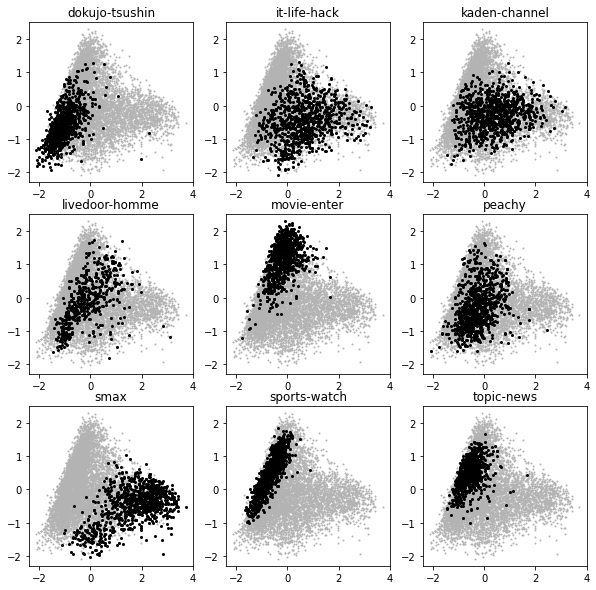

In [9]:
# 文章ベクトルをカテゴリごとにプロットしてみる

plt.figure(figsize=(10,10))

for label in range(9):
    plt.subplot(3,3,label+1)

    # 配列 labelsの要素とlabelが等しければ、その位置にTrue, そうでなければfalseを入れた配列index
    # 配列名[条件式] で、配列中の要素のうち条件がTrueのものだけ取得できる
    # https://oregengo.hatenablog.com/entry/2016/06/07/002011
    index = labels == label
    print(index)

    # 参考のため、全てのグラフにデータ全体の文章ベクトルを灰色でプロット
    plt.plot(
        sentence_vectors_pca[:,0], 
        sentence_vectors_pca[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )

    # 該当labelの文章ベクトルをプロット
    plt.plot(
        sentence_vectors_pca[index,0], 
        sentence_vectors_pca[index,1], 
        'o', 
        markersize=2, 
        color='k'
    )

    # 最後にカテゴリ名をプリント
    plt.title(category_list[label])

    '''
    結果は同じカテゴリの文章はクラスタ性を見せるが
    カテゴリごとのオーバーラップは大きめ
    '''

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


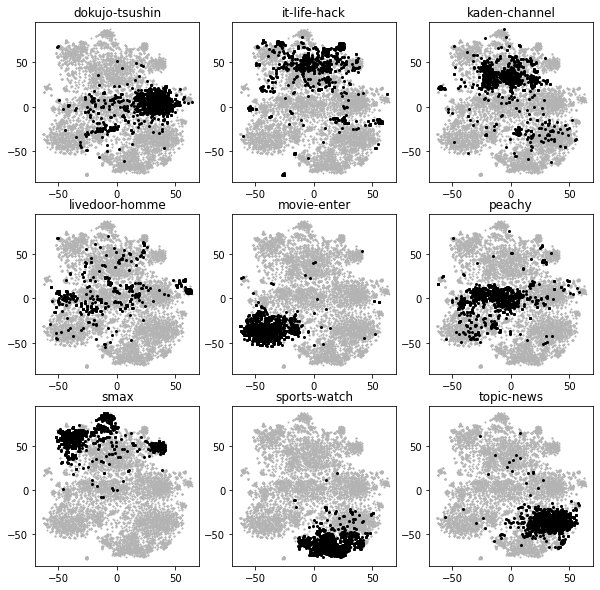

In [10]:
# t-SNEで次元削減してみよう
sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors)    

# プロット
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_tsne[:,0],
        sentence_vectors_tsne[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_tsne[index,0],
        sentence_vectors_tsne[index,1], 
        'o',
        markersize=2,
        color='k'
    )
    plt.title(category_list[label])

    '''
    主成分分析よりも
    クラスタ性が強い
    オーバーラップが少ない
    '''

In [11]:
'''
類似文章検索を使用

コサイン類似度を使って文章同士の類似度を求めることで、似た文章を検索する

入力：文章
出力：同じカテゴリの文章を出力したら成功・そうでなければ失敗
'''

# 先にノルムを1にしておく。これによって、ベクトルの内積 == コサイン類似度　になる
# linalg.norm : https://www.sejuku.net/blog/73783
# ベクトルの大きさを計算
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True) 
sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算する。
# 類似度行列の(i,j)要素はi番目の記事とj番目の記事の類似度を表している。
# dotは配列の掛け算
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 入力と同じ記事が出力されることを避けるため、
# 類似度行列の対角要素の値を小さくしておく。
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る
# axis : https://deepage.net/features/numpy-argmax.html
# 各行の最大値のindexが帰ってくる
similar_news = sim_matrix.argmax(axis=1) 

# 類似文章検索により選ばれた記事とカテゴリーが同一であった記事の割合を計算
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = ( input_news_categories == output_news_categories ).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83
